# Importing training Data
TODO: dealing with test data loading

In [22]:
import numpy as np
from glob import glob
import omegaconf
from utils.data import DataLoader
import matplotlib.pyplot as plt



In [2]:
conf = omegaconf.OmegaConf.load('configs/baseConfig.yaml')

In [3]:

trainLoader = DataLoader(**conf.LoaderParams)
batch = next(iter(trainLoader))
print(batch.shape)

(32, 200, 45, 3)


In [14]:
y = batch[:,:,0]
xl = batch[:,:,1]


In [21]:
sampley = y[0]
sampleX = xl[0]


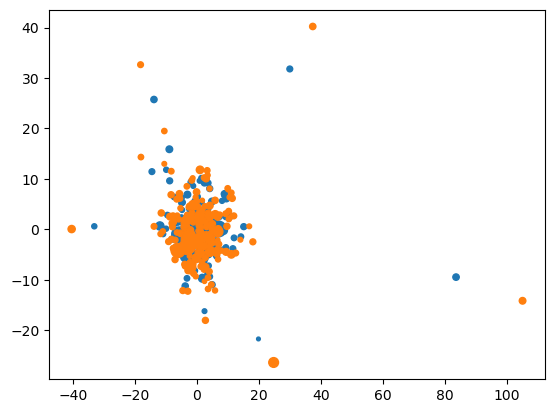

In [25]:
plt.scatter(sampley[:,0], sampley[:,1],s=sampley[:,2]*1000)
plt.scatter(sampleX[:,0], sampleX[:,1],s=sampleX[:,2]*1000)
plt.show()

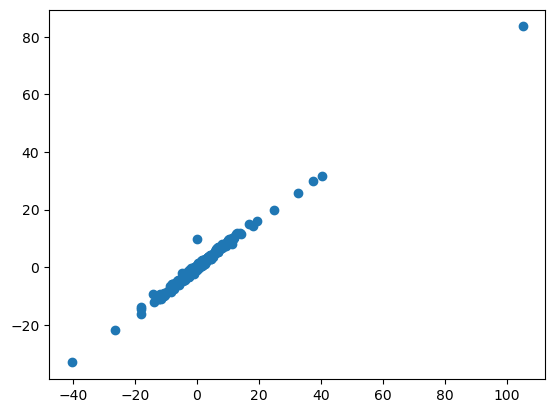

In [ ]:
plt.scatter(y[0])

# Model testings

In [4]:
from utils.model import PosPredictor

/home/bdudas/anaconda3/envs/pct/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [6]:
model = PosPredictor(**conf.ModelParams)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.compile(optimizer=optim.Adam,loss=nn.MSELoss,device = device)

cuda


In [8]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
logdir = writer.log_dir
with open(f'{logdir}/config.yaml', 'w') as f:
    omegaconf.OmegaConf.save(conf, f)
model.add_logger(writer)

2025-02-21 20:49:19.878014: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [9]:

model.fit(trainLoader,epochs=10)


Epoch: 0
Loss: 58.35295867919922
Loss: 42.41501235961914
Loss: 37.06358337402344
Loss: 32.132843017578125
Loss: 20.610342025756836
Loss: 16.034456253051758
Loss: 11.113333702087402
Loss: 9.770401954650879
Loss: 8.253222465515137
Loss: 8.188796043395996
Loss: 6.90907096862793
Loss: 6.942159175872803
Loss: 7.702142238616943
Loss: 4.15455436706543
Loss: 6.267499923706055
Loss: 6.571926593780518
Loss: 6.489777088165283
Loss: 9.059404373168945
Loss: 9.861527442932129
Loss: 9.704200744628906
Loss: 10.198890686035156
Loss: 5.886663913726807
Loss: 4.740919589996338
Loss: 6.017339706420898
Loss: 4.66391134262085
Loss: 6.022830963134766


KeyboardInterrupt: 